Import e Configuração

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.preprocessing import StandardScaler


In [3]:
# Configura a visualização dos graficos
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['font.size'] = 22

Leitura dos dados e visualização

In [5]:
# Import e visualização dos dados
arquivos = ['BAC.csv','F.csv','KO.csv','PFE.csv']

# Import e visualização dos dados
dfs = {}
for arquivo in arquivos:
    key = arquivo.replace('.csv','')

    df = pd.read_csv(arquivo)
    df.Date = pd.to_datetime(df.Date)
    dfs[key] = df

    print(f'>> Visualizando dados da ação: {key}')
    print(dfs[arquivo.replace('.csv','')].head())
    print('')

>> Visualizando dados da ação: BAC
        Date       Open       High        Low      Close  Adj Close    Volume
0 2022-11-14  38.090000  38.259998  37.750000  37.759998  36.697521  35541400
1 2022-11-15  38.189999  38.299999  37.299999  37.700001  36.639210  46082800
2 2022-11-16  37.610001  37.740002  37.200001  37.360001  36.308781  23813000
3 2022-11-17  36.880001  37.200001  36.560001  37.169998  36.124119  23689700
4 2022-11-18  37.790001  37.849998  36.919998  37.189999  36.143562  32041800

>> Visualizando dados da ação: F
        Date  Open  High   Low  Close  Adj Close    Volume
0 2018-11-14  9.63  9.67  9.43   9.54   7.670632  46677600
1 2018-11-15  9.50  9.53  9.12   9.31   7.485702  57170100
2 2018-11-16  9.28  9.31  8.98   9.05   7.276650  54582500
3 2018-11-19  9.02  9.36  8.96   9.25   7.437460  56292500
4 2018-11-20  9.10  9.22  9.01   9.06   7.284689  35159900

>> Visualizando dados da ação: KO
        Date       Open       High        Low      Close  Adj Close    Vol

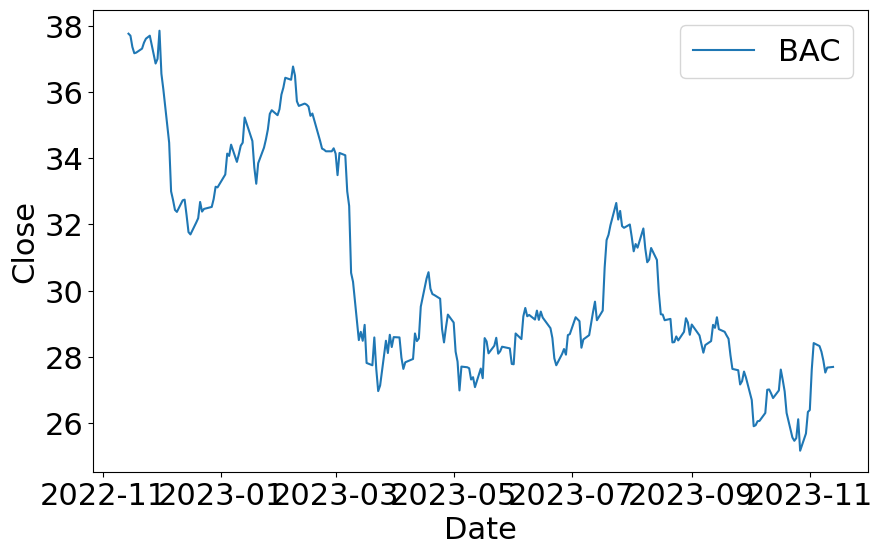

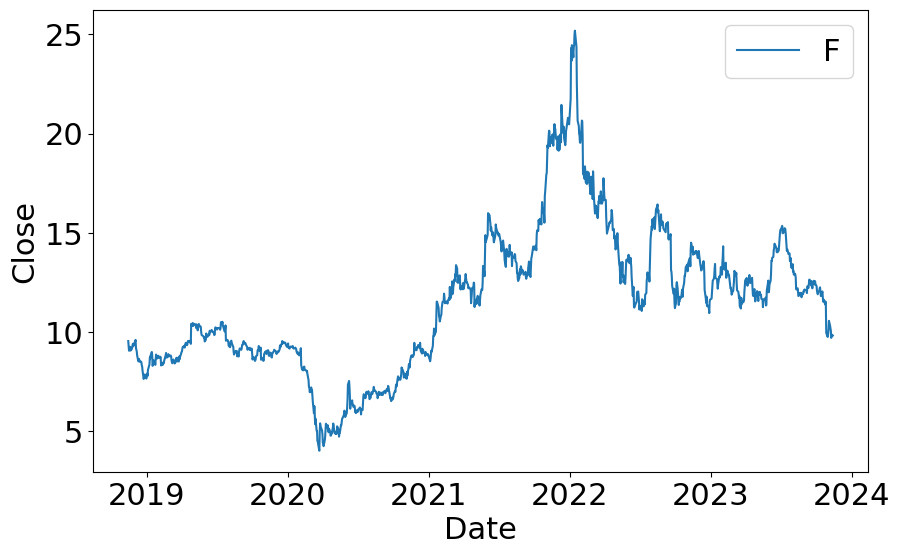

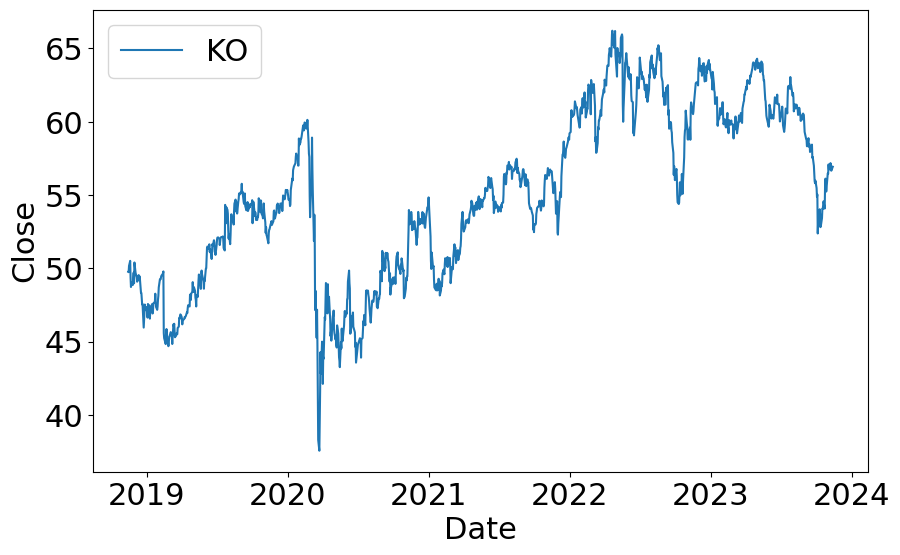

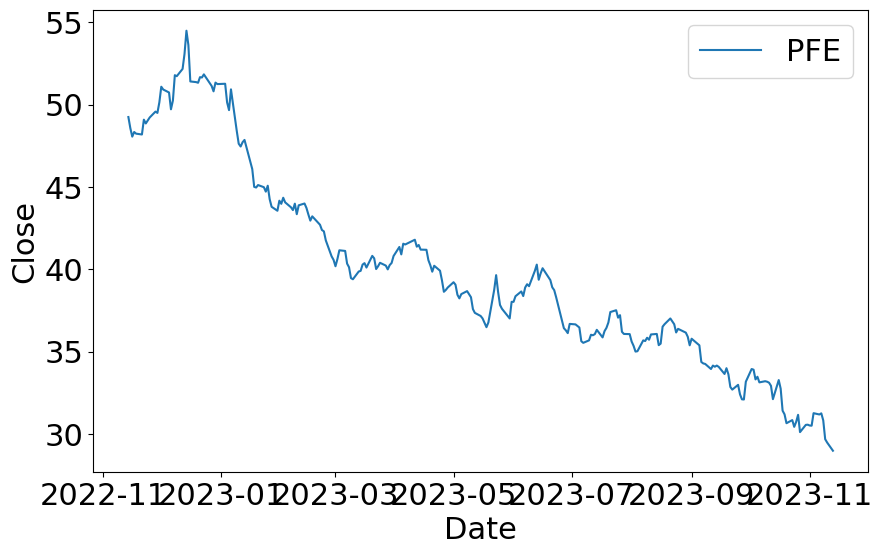

<Figure size 1000x600 with 0 Axes>

In [6]:
# Vizualizando grafico de dados
for key in dfs.keys():
    sns.lineplot(x='Date',y='Close',data=dfs[key][['Date', 'Close']], label=key)
    plt.figure()

Pré Processamento

In [19]:
scs = {}
dados_escalados = {}
xs = {}
ys = {}

for key in dfs.keys():
    df = dfs[key][['Date','Close']]
    df.Date = df.Date.apply(lambda x: x.timestamp())

    #Instancia no modelo os dados
    sc = StandardScaler()

    #Instancia no modelo os dados
    sc.fit(df)
    scs[key] = sc

    #Escala os dados para aplicar ao modelo de IA
    dado_escalado = sc.transform(df)
    dados_escalados[key] = dado_escalado

    #Define X e Y dos dados
    x = dado_escalado[:,0]
    xs[key] = x

    y = dado_escalado[:,1]
    ys[key] = y


<ipython-input-19-cbe8cd1814b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Date = df.Date.apply(lambda x: x.timestamp())
<ipython-input-19-cbe8cd1814b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Date = df.Date.apply(lambda x: x.timestamp())
<ipython-input-19-cbe8cd1814b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [64]:
#Retira os dados de treino e teste
tamanhos_treinos = {}
tamanhos_testes = {}
xtreinos = {}
ytreinos = {}
xtestes = {}
ytestes = {}

for key in dfs.keys():
  print(f">> Separando dados de treino e teste para {key}")
  df = dfs[key]

  tamanho_treino = int(len(df)*0.9)
  tamanho_teste = len(df) - tamanho_treino

  xtreino = xs[key][0:tamanho_treino]
  ytreino = ys[key][0:tamanho_treino]

  xteste = xs[key][tamanho_treino:len(df)]
  yteste = ys[key][tamanho_treino:len(df)]

  tamanhos_treinos[key] = tamanho_treino
  tamanhos_testes[key] = tamanho_teste
  xtreinos[key] = xtreino
  ytreinos[key] = ytreino
  xtestes[key] = xteste
  ytestes[key] = yteste

>> Separando dados de treino e teste para BAC
>> >> Tamanho do treino: 225
>> >> Tamanho do treino: 225
>> Separando dados de treino e teste para F
>> >> Tamanho do treino: 1131
>> >> Tamanho do treino: 1131
>> Separando dados de treino e teste para KO
>> >> Tamanho do treino: 1131
>> >> Tamanho do treino: 1131
>> Separando dados de treino e teste para PFE
>> >> Tamanho do treino: 225
>> >> Tamanho do treino: 225


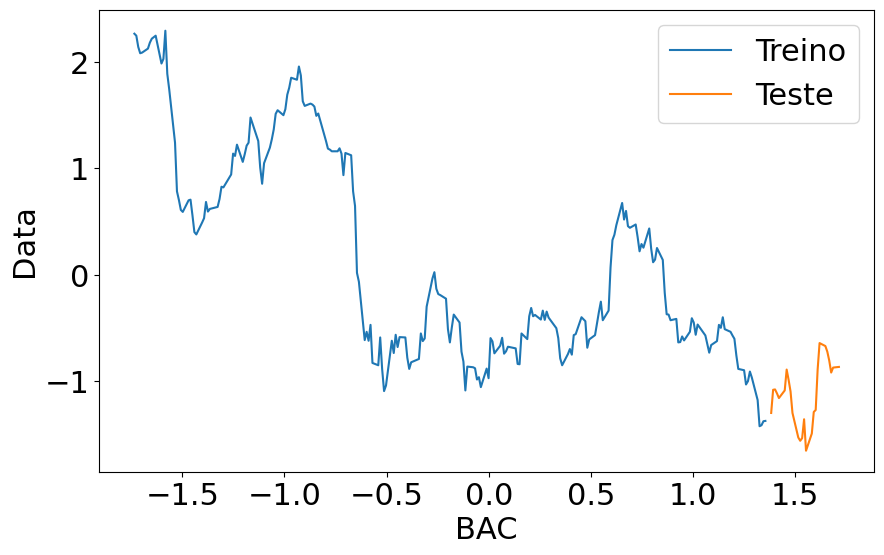

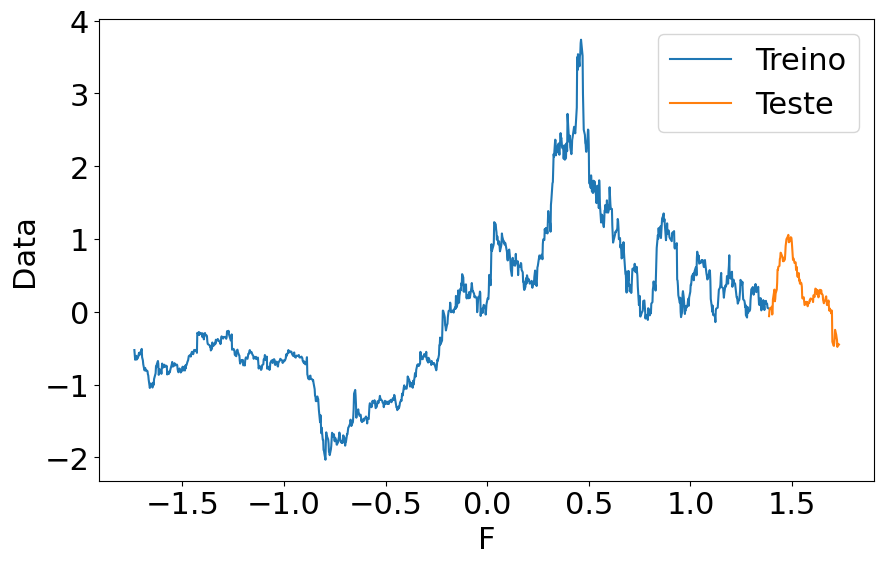

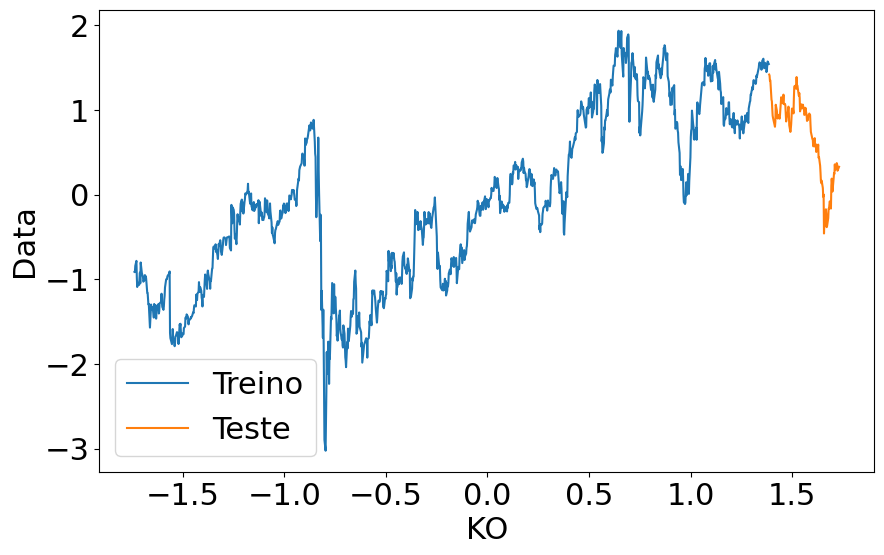

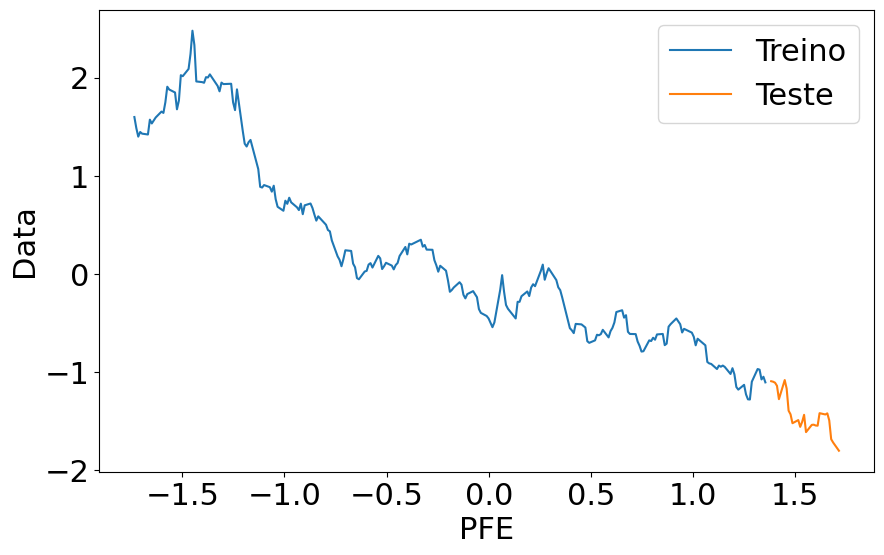

<Figure size 1000x600 with 0 Axes>

In [43]:
#Visualiza dados de treino e teste
for key in dfs.keys():
  sns.lineplot(x=xtreinos[key],y=ytreinos[key],label='Treino')
  sns.lineplot(x=xtestes[key],y=ytestes[key],label='Teste')
  plt.xlabel(key)
  plt.ylabel('Data')
  plt.figure()

# Função Sigmod
### 3 Camadas

In [104]:
def separa_dados(vetor,n_passos):
  X_novo,Y_novo = [], []

  for i in range(n_passos, vetor.shape[0]):
    X_novo.append(list(vetor.loc[i-n_passos:i-1]))
    Y_novo.append(vetor.loc[i])
  X_novo, Y_novo = np.array(X_novo), np.array(Y_novo)

  return X_novo, Y_novo

vetores = {}
xtreinos_novos = {}
vetores2= {}
xtestes_novos = {}
ytreinos_novos = {}
ytestes_novos = {}
for key in dfs.keys():
  print(f">> Separação dos dados para predição do futuro {key}")

  vetor = pd.DataFrame(ytreinos[key])[0]
  xtreino_novo,ytreino_novo = separa_dados(vetor,1)

  vetor2 = pd.DataFrame(ytestes[key])[0]
  xteste_novo,yteste_novo = separa_dados(vetor2,1)

  vetores[key] = vetor
  xtreinos_novos[key] = xtreino_novo
  ytreinos_novos[key] = ytreino_novo
  vetores2[key] =  vetor2
  xtestes_novos[key] = xteste_novo
  ytestes_novos[key] = yteste_novo

  print(f">> ytreino {len(ytreino_novo)}")

>> Separação dos dados para predição do futuro BAC
>> ytreino 224
>> Separação dos dados para predição do futuro F
>> ytreino 1130
>> Separação dos dados para predição do futuro KO
>> ytreino 1130
>> Separação dos dados para predição do futuro PFE
>> ytreino 224


In [48]:
def treina_modelo(params, input, xtreino, ytreino, epoch):

  regressor = Sequential()
  # Faz a ativação linear (Wx+b):   o primeiro parametro é a quantidade de camadas
  #                                 input_dim diz que a regressão terá apenas uma entrada
  #                                 kernel_initializer diz que o W começara apenas como 1
  #                                 use_bias informa que terá o b como parametro da regressão
  #                                 activation é a função de ativação da rede neural

  #Adiciona ao modelo as camdas
  index = 1
  for camada, kernel, activador in params:
    if index == 1:
      regressor.add(Dense(camada,input_dim=input,kernel_initializer=kernel,activation=activador,use_bias=False))
    else:
      regressor.add(Dense(camada,kernel_initializer=kernel,activation=activador,use_bias=False))
    index = index + 1

  # Parametriza o modelo, modelo de perda a ser minimizado e optimizer é o otimizador (ele é responsavel pela atualização dos pesos)
  regressor.compile(loss='mean_squared_error', optimizer='adam')

  #Treino da rede
  regressor.fit(xtreino,ytreino,epochs=epoch)

  return regressor


#Camadas dos modelos (camadas, Kernel_initializer, activation)
params = [
          (8 ,'one'           ,'sigmoid'),
          (64,'random_uniform','sigmoid'),
          (1 ,'random_uniform','linear' )
         ]
regressores = {}
for key in dfs.keys():
  regressor = treina_modelo(params, 1, xtreinos_novos[key], ytreinos_novos[key], 200)
  regressores[key] = regressor

Epoch 1/200
7/7 [==============================] - 1s 3ms/step - loss: 0.8686
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8361
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8349
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8228
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8139
Epoch 6/200
7/7 [==============================] - 0s 4ms/step - loss: 0.8069
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 0.8013
Epoch 8/200
7/7 [==============================] - 0s 4ms/step - loss: 0.7939
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 0.7806
Epoch 10/200
7/7 [==============================] - 0s 3ms/step - loss: 0.7717
Epoch 11/200
7/7 [==============================] - 0s 2ms/step - loss: 0.7598
Epoch 12/200
7/7 [==============================] - 0s 2ms/step - loss: 0.7472
Epoch 13/200
7/7 [==============================] - 0s 4ms/st

In [143]:
ypredict_novos = {}
ypredict_testes_novos = {}
for key in dfs.keys():
  print(f">> Predição do modelo {key}")
  ypredict_novos[key] = regressores[key].predict(xtreinos_novos[key])
  ypredict_testes_novos[key] = regressores[key].predict(xtestes_novos[key])

  print(f">> Tamanho do df {len(dfs[key])}")
  print(f">> Tamanho do ypredict_novos {len(ypredict_novos[key])}")
  print(f">> Tamanho do ypredict_testes_novos {len(ypredict_testes_novos[key])}")

>> Predição do modelo BAC
1/1 [==============================] - 0s 40ms/step
>> Tamanho do df 251
>> Tamanho do ypredict_novos 224
>> Tamanho do ypredict_testes_novos 25
>> Predição do modelo F
4/4 [==============================] - 0s 5ms/step
>> Tamanho do df 1257
>> Tamanho do ypredict_novos 1130
>> Tamanho do ypredict_testes_novos 125
>> Predição do modelo KO
4/4 [==============================] - 0s 5ms/step
>> Tamanho do df 1257
>> Tamanho do ypredict_novos 1130
>> Tamanho do ypredict_testes_novos 125
>> Predição do modelo PFE
1/1 [==============================] - 0s 38ms/step
>> Tamanho do df 251
>> Tamanho do ypredict_novos 224
>> Tamanho do ypredict_testes_novos 25


In [61]:
#len(dfs['F'])
len(ytreinos_novos[key])
#tamanhos_treinos['F']
#df[1:tamanhos_treinos[key]]

224

In [120]:
#teste = pd.DataFrame(ypredict_testes_novos[key])[0]
print(f"tamanho do y {len(teste)}")
print(f"chave {key}")
print(f"ny_treino_novo {ny_treino_novo}")
print(f"tamanho df {len(dfs[key])}")

tamanho do y 25
chave F
ny_treino_novo 1131
tamanho df 1257


In [151]:
#len(ytreinos_novos[key])
#key

#len(dfs[key][ny_teste_novo+1:])
#len(teste)
#teste = pd.DataFrame(ypredict_testes_novos[key])
#len(ytestes_novos[key]) + 1

226

>> Plotando resultado de BAC
>> Plotando resultado de F
>> Plotando resultado de KO
>> Plotando resultado de PFE


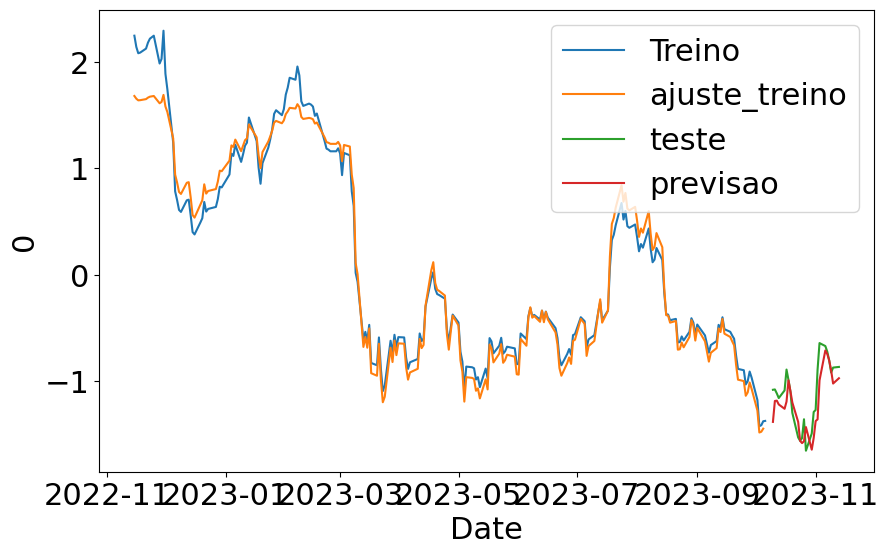

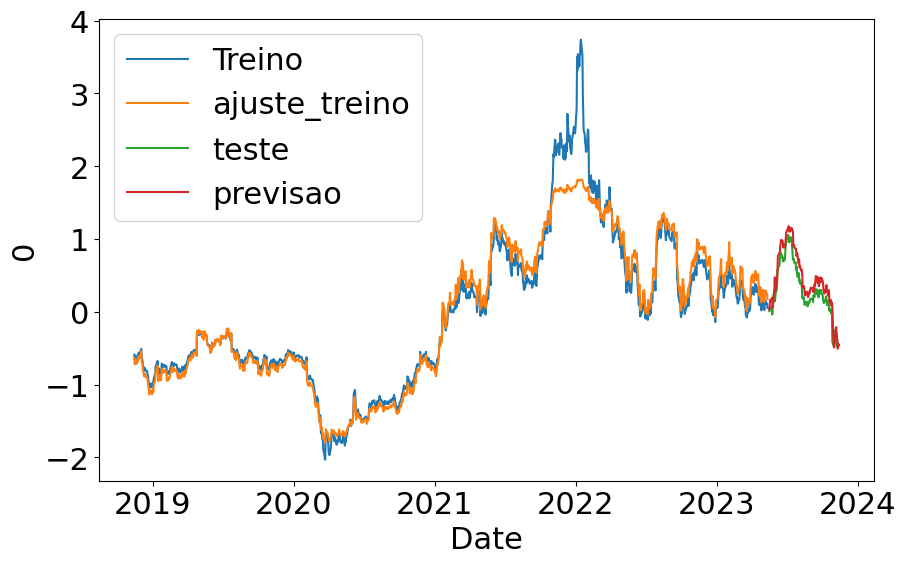

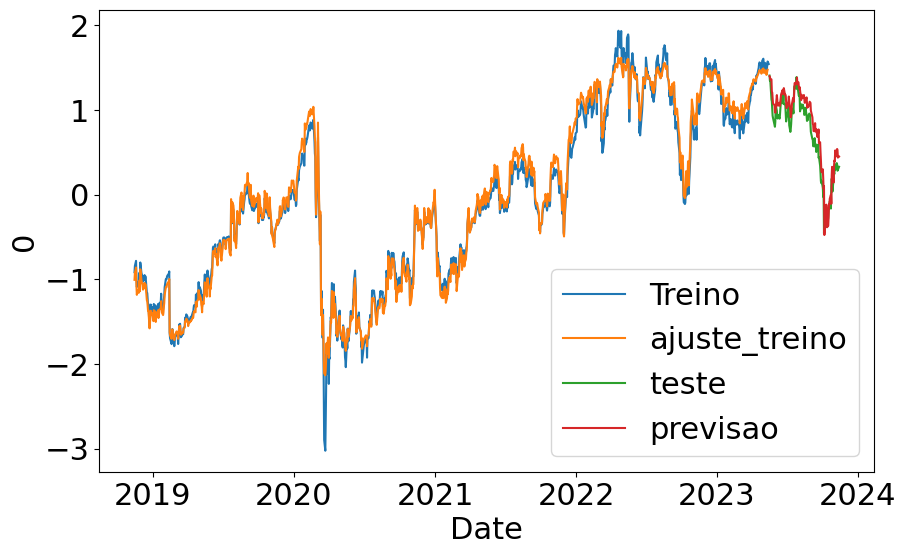

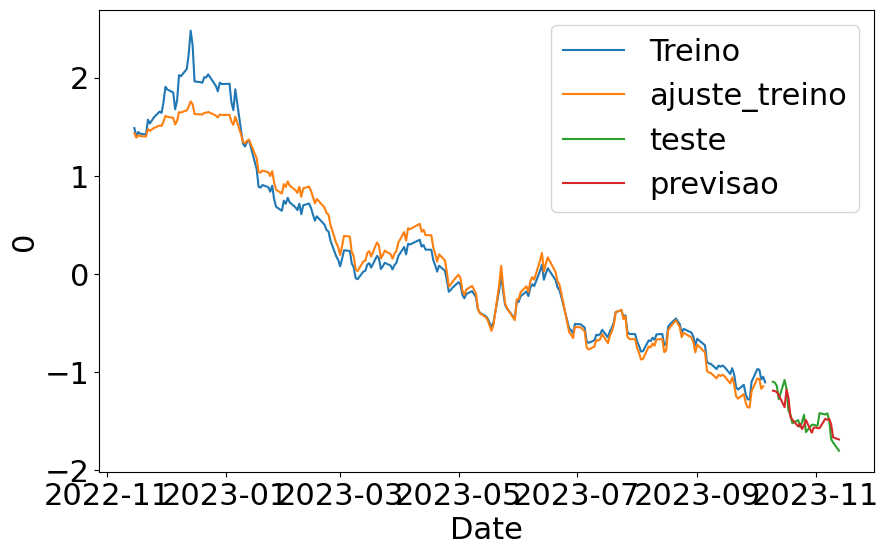

<Figure size 1000x600 with 0 Axes>

In [154]:
#Plotagem do resultado
for key in dfs.keys():
  print(f">> Plotando resultado de {key}")
  df = dfs[key]
  ny_treino_novo = len(ytreinos_novos[key]) + 1
  ny_teste_novo = len(dfs[key]) - len(ypredict_testes_novos[key]) -1

  sns.lineplot(x='Date', y=ytreinos_novos[key], data=df[1:ny_treino_novo], label='Treino')
  sns.lineplot(x='Date', y=pd.DataFrame(ypredict_novos[key])[0], data=df[1:ny_treino_novo], label='ajuste_treino')
  sns.lineplot(x='Date', y=ytestes_novos[key], data=df[ny_treino_novo+1:], label='teste')
  sns.lineplot(x='Date', y=pd.DataFrame(ypredict_testes_novos[key])[0].values, data=df[ny_teste_novo+1:], label='previsao')
  plt.figure()

Usando janela de 4 times

In [155]:
xTreinos_novos = {}
yTreinos_novos = {}
xtestes_novos = {}
ytestes_novos = {}

for key in dfs.keys():
  xTreino_novo, yTreino_novo = separa_dados(vetores[key],4)
  xteste_novo, yteste_novo = separa_dados(vetores2[key],4)

  xTreinos_novos[key] = xTreino_novo
  yTreinos_novos[key] = yTreino_novo
  xtestes_novos[key] = xteste_novo
  ytestes_novos[key] = yteste_novo



In [156]:
params = [
          (8 ,'one'           ,'linear'),
          (64,'random_uniform','sigmoid'),
          (1 ,'random_uniform','linear' )
         ]
regressores4 = {}
for key in dfs.keys():
  regressores4[key] = treina_modelo(params, 4, xTreinos_novos[key], yTreinos_novos[key], 300)

Epoch 1/300
7/7 [==============================] - 2s 4ms/step - loss: 0.8702
Epoch 2/300
7/7 [==============================] - 0s 3ms/step - loss: 0.6927
Epoch 3/300
7/7 [==============================] - 0s 5ms/step - loss: 0.5382
Epoch 4/300
7/7 [==============================] - 0s 8ms/step - loss: 0.3911
Epoch 5/300
7/7 [==============================] - 0s 3ms/step - loss: 0.2586
Epoch 6/300
7/7 [==============================] - 0s 4ms/step - loss: 0.1647
Epoch 7/300
7/7 [==============================] - 0s 4ms/step - loss: 0.1046
Epoch 8/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0835
Epoch 9/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0774
Epoch 10/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0782
Epoch 11/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0778
Epoch 12/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0766
Epoch 13/300
7/7 [==============================] - 0s 5ms/st

In [161]:
#Predição
y_predict_novos = {}
y_predict_testes_novos = {}
resultados_treinos = {}
resultados = {}

for key in dfs.keys():
  y_predict_novo = regressores4[key].predict(xTreinos_novos[key])
  y_predict_teste_novo = regressores4[key].predict(xtestes_novos[key])

  resultado_treino = pd.DataFrame(y_predict_novo)[0]
  resultado = pd.DataFrame(y_predict_teste_novo)[0]

  y_predict_novos[key] = y_predict_novo
  y_predict_testes_novos[key] = y_predict_teste_novo
  resultados_treinos[key] = resultado_treino
  resultados[key] = resultado

1/1 [==============================] - 0s 20ms/step


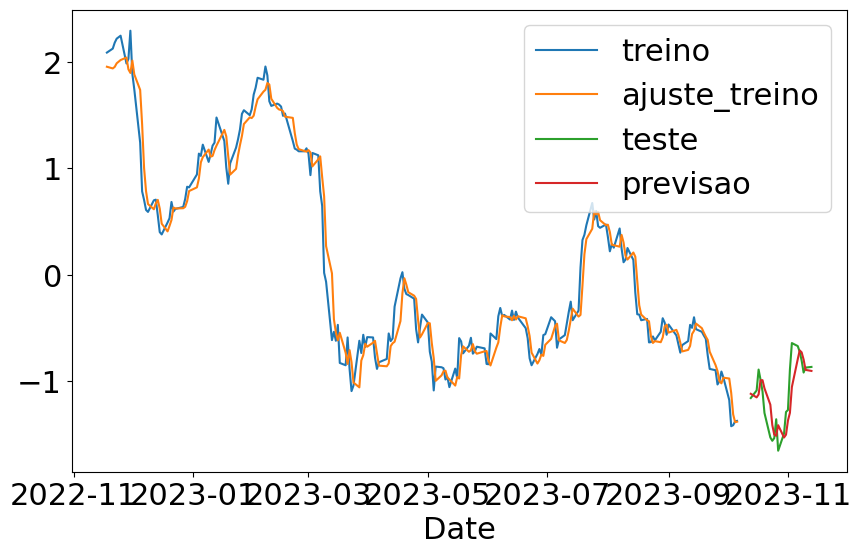

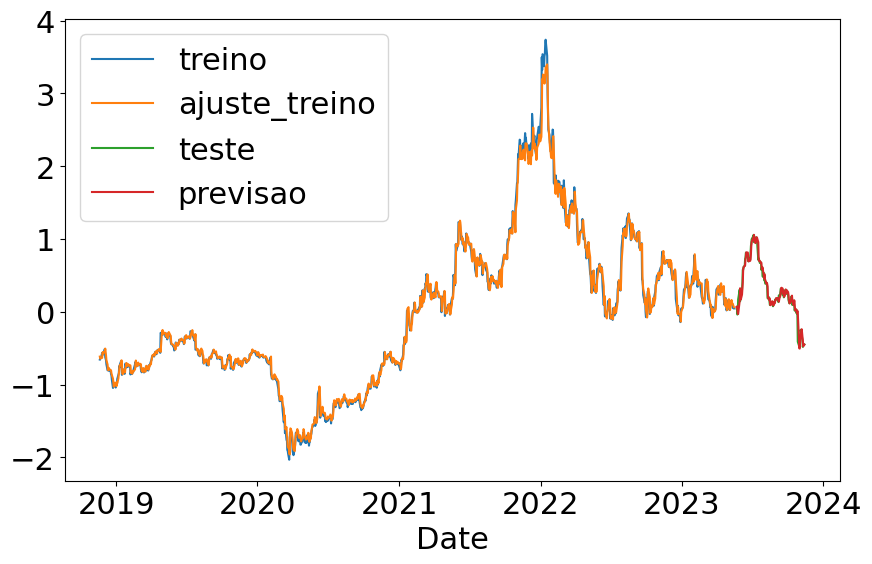

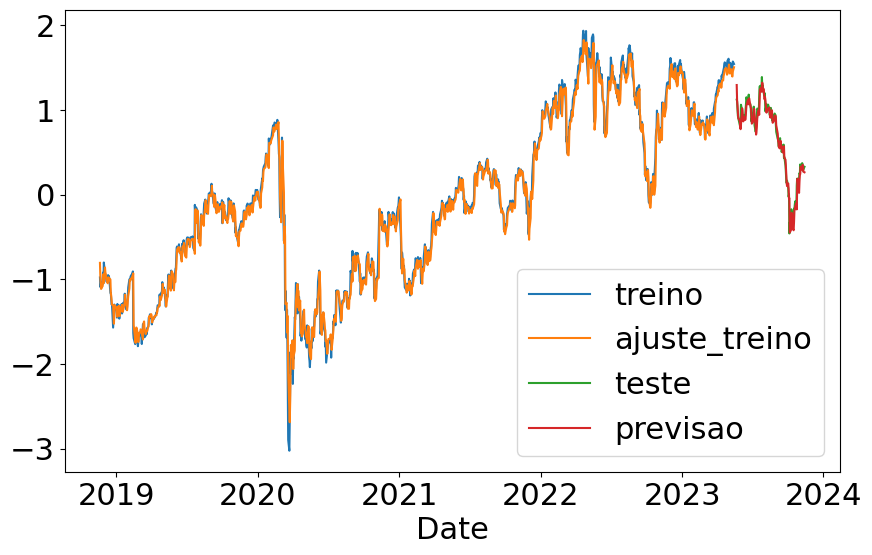

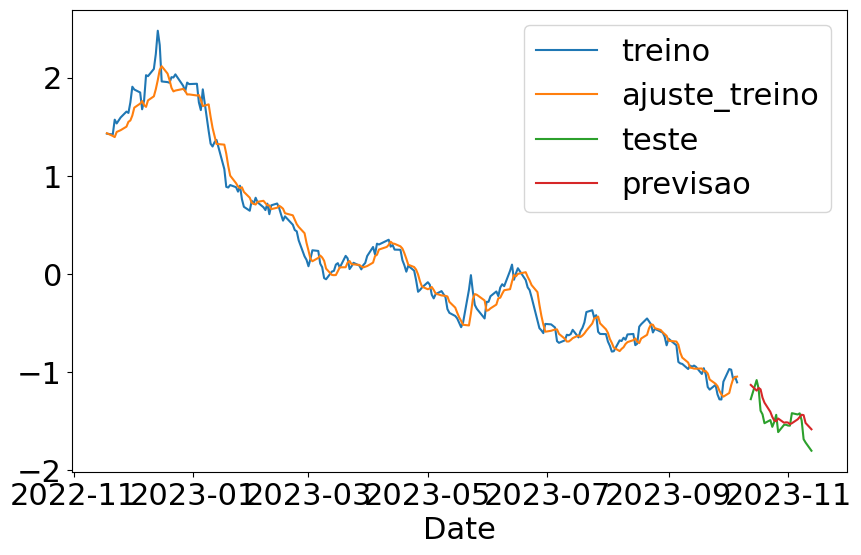

<Figure size 1000x600 with 0 Axes>

In [166]:
for key in dfs.keys():
  df = dfs[key]
  n_yTreinos_novos = len(yTreinos_novos[key]) + 4

  sns.lineplot(x='Date', y=yTreinos_novos[key],data=df[4:n_yTreinos_novos], label='treino')
  sns.lineplot(x='Date', y=resultados_treinos[key].values,data=df[4:n_yTreinos_novos], label='ajuste_treino')
  sns.lineplot(x='Date', y=ytestes_novos[key],data=df[n_yTreinos_novos + 4:], label='teste')
  sns.lineplot(x='Date', y=resultados[key].values,data=df[n_yTreinos_novos+4:], label='previsao')
  plt.figure()